# MLP - IRIS Dataset

## IRIS Dataset

IRIS dataset is downloaded from <https://archive.ics.uci.edu/ml/datasets/iris>.

The dataset consists of three classes and four features. Each class has 50 samples and the dataset has 150 samples in total. 
The is in text format every line has input feature and label. 


In [38]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import random

#First open and read the file
f = open("iris.data", "r")
data = f.read()
#Split each line and create the list
data_list = data.split("\n")

#Seperate each data
data_seperate = []
dataset = []
for i in range(len(data_list)):
    dataset.append([])
    data_seperate = data_list[i].split(",")
    x1 = float(data_seperate[0])
    x2 = float(data_seperate[1])
    x3 = float(data_seperate[2])
    x4 = float(data_seperate[3])

    if data_seperate[4] == "Iris-virginica":
        y = 2
    elif data_seperate[4] == "Iris-versicolor":
        y = 1
    elif data_seperate[4] == "Iris-setosa":
        y = 0

    dataset[i].append([x1, x2, x3, x4, y])

#Now we will seperate 40 of each class to train set and remaining 10 to test set, we will also shuffle the selections
train = int(40)
dataset = np.array(dataset, dtype=np.float32).reshape(150, 5)
cls1 = np.arange(50, dtype=np.int)
random.shuffle(cls1)
cls1_train = cls1[0: train]
cls1_test = cls1[train:]

cls2 = np.arange(50, 100, dtype=np.int)
random.shuffle(cls2)
cls2_train = cls2[0: train]
cls2_test = cls2[train:]

cls3 = np.arange(100, 150, dtype=np.int)
random.shuffle(cls3)
cls3_train = cls3[0: train]
cls3_test = cls3[train:]

#Lastly birng all the data
dataset_train = dataset[np.concatenate((cls1_train, cls2_train, cls3_train)), :]
dataset_test = dataset[np.concatenate((cls1_test, cls2_test, cls3_test)), :]
print(dataset_train.shape, dataset_test.shape)
print(dataset_train[0])


(120, 5) (30, 5)
[4.9 3.1 1.5 0.1 0. ]


### Utility Functions

Now as outputs we have numbers 0 1 2, but the outputs of the network will be 0 0 1 or 0.5 0.4 0.1 we need to vectorize the labels


In [39]:
def labels_to_vector(labels):
    result = np.zeros((3, 1))
    result[labels, 0] = 1
    return result

print(labels_to_vector([0]))
print(labels_to_vector([1]))
print(labels_to_vector([2]))

def vector_to_labels(labels):
    return np.array([np.argmax(labels)])

print(vector_to_labels([0.1, 0.5, 0.3]))
print(vector_to_labels([0, 0, 1]))

def mean_square_error(ground_truth, desired):
    temp = np.square(ground_truth - desired)
    temp = np.mean( temp )
    return temp

[[1.]
 [0.]
 [0.]]
[[0.]
 [1.]
 [0.]]
[[0.]
 [0.]
 [1.]]
[1]
[2]


## MLP 

Redefine to solve this problem MLP with 4 inputs, 20 neurons, 10 neurons, and 3 output neurons. 

In [40]:

input_dimension = 4
input_data = dataset_train[0][0:-1].reshape(-1, 1)
ground_truth = labels_to_vector( int(dataset_train[0][-1]) )

layer_0 = 20
layer_1 = 10
layer_out = 3

#Keep in mind the bias weights, all the weights are sampled from uniform distribution between 0 and 1. The substraction makes it -0.5 and 0.5.
weights_0 = np.random.rand(layer_0, input_dimension + 1) - 0.5
weights_1 = np.random.rand(layer_1, layer_0 + 1) - 0.5
weights_out = np.random.rand(layer_out, layer_1 + 1) - 0.5



## Training Loop


In [41]:
max_epoch = 1000 #Number of maximum epochs
lr = 1e-2

mse_train = [] #Buffer for error
mse_test = []
for epoch in range(max_epoch):
    mse_epoch = 0
    #Train loop
    #Shuffle the indices
    indices = np.arange(len(dataset_train))
    random.shuffle(indices)
    for train_index in indices:
        #Inference
        input_data = dataset_train[train_index][0:-1].reshape(-1, 1)
        ground_truth = labels_to_vector( int(dataset_train[train_index][-1]) )

        input_0 = np.concatenate((input_data, np.ones((1,1))))
        lin_comb_0 = np.matmul(weights_0, input_0) #v
        output_0 = np.tanh(lin_comb_0) #y

        #Add bias to output 0
        input_1 = np.concatenate((output_0, np.ones((1,1))))

        lin_comb_1 = np.matmul(weights_1, input_1) #v
        output_1 = np.tanh(lin_comb_1) #y

        #Add bias to output 1
        input_out = np.concatenate((output_1, np.ones((1,1))))

        lin_comb_out = np.matmul(weights_out, input_out) #v
        output_out = np.tanh(lin_comb_out) #y

        #Error
        mse_epoch += mean_square_error(ground_truth, output_out)
        error = ground_truth - output_out 

        #Backpropagation
        local_gradient_out = error * -1 * (1 - output_out**2)

        weight_out_temp = np.transpose(weights_out[:, :-1]) #no bias and transpose
        temp1 = np.matmul(weight_out_temp, local_gradient_out)
        local_gradient_1 = temp1 * (1 - output_1**2)

        weight_1_temp = np.transpose(weights_1[:, :-1]) #no bias and transpose
        temp0 = np.matmul(weight_1_temp, local_gradient_1)
        local_gradient_0 = temp0 * (1 - output_0**2)
 
        #Calculate derivatives
        derivative_out = np.matmul(local_gradient_out, input_out.transpose())
        derivative_1 = np.matmul(local_gradient_1, input_1.transpose())
        derivative_0 = np.matmul(local_gradient_0, input_0.transpose())

        #Weight update
        weights_0 = weights_0 - lr * derivative_0
        weights_1 = weights_1 - lr * derivative_1
        weights_out = weights_out - lr * derivative_out
    
    mse_train.append(mse_epoch/len(dataset_train))

    mse_epoch = 0
    test_gt = np.array([])
    test_pred = np.array([])
    #Test loop
    #Shuffle the indices
    indices = np.arange(len(dataset_test))
    random.shuffle(indices)
    for test_index in indices:
        #Inference
        input_data = dataset_test[test_index][0:-1].reshape(-1, 1)
        ground_truth = labels_to_vector( int(dataset_test[test_index][-1]) )

        input_0 = np.concatenate((input_data, np.ones((1,1))))
        lin_comb_0 = np.matmul(weights_0, input_0) #v
        output_0 = np.tanh(lin_comb_0) #y

        #Add bias to output 0
        input_1 = np.concatenate((output_0, np.ones((1,1))))

        lin_comb_1 = np.matmul(weights_1, input_1) #v
        output_1 = np.tanh(lin_comb_1) #y

        #Add bias to output 1
        input_out = np.concatenate((output_1, np.ones((1,1))))

        lin_comb_out = np.matmul(weights_out, input_out) #v
        output_out = np.tanh(lin_comb_out) #y

        #Error
        mse_epoch += mean_square_error(ground_truth, output_out)

        test_gt = np.concatenate( (test_gt, vector_to_labels(ground_truth)) )
        test_pred = np.concatenate( (test_pred, vector_to_labels(output_out)) )
        
    mse_test.append(mse_epoch/len(dataset_train))

    print("Epoch: %d, Training MSE: %f, Test MSE: %f"%(epoch, mse_train[-1], mse_test[-1]))

    cm = confusion_matrix(test_gt, test_pred)
    print("Confusion matrix:")
    print(cm)

    #End condition
    if(mse_test[-1] < 0.002):
        break

Epoch: 0, Training MSE: 0.181969, Test MSE: 0.029726
Confusion matrix:
[[10  0  0]
 [ 0  8  2]
 [ 0  3  7]]
Epoch: 1, Training MSE: 0.113081, Test MSE: 0.027412
Confusion matrix:
[[10  0  0]
 [ 0 10  0]
 [ 0  8  2]]
Epoch: 2, Training MSE: 0.104595, Test MSE: 0.025192
Confusion matrix:
[[10  0  0]
 [ 0 10  0]
 [ 0  4  6]]
Epoch: 3, Training MSE: 0.096930, Test MSE: 0.023799
Confusion matrix:
[[10  0  0]
 [ 0 10  0]
 [ 0  4  6]]
Epoch: 4, Training MSE: 0.089003, Test MSE: 0.021810
Confusion matrix:
[[10  0  0]
 [ 0 10  0]
 [ 0  4  6]]
Epoch: 5, Training MSE: 0.077554, Test MSE: 0.018562
Confusion matrix:
[[10  0  0]
 [ 0  7  3]
 [ 0  0 10]]
Epoch: 6, Training MSE: 0.075367, Test MSE: 0.017442
Confusion matrix:
[[10  0  0]
 [ 0 10  0]
 [ 0  2  8]]
Epoch: 7, Training MSE: 0.062654, Test MSE: 0.019649
Confusion matrix:
[[10  0  0]
 [ 0  3  7]
 [ 0  0 10]]
Epoch: 8, Training MSE: 0.058851, Test MSE: 0.014060
Confusion matrix:
[[10  0  0]
 [ 0  8  2]
 [ 0  0 10]]
Epoch: 9, Training MSE: 0.05

79 79
79 79


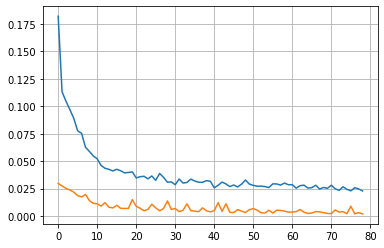

In [42]:
print(epoch + 1, len(mse_train))
print(epoch + 1, len(mse_test))
plt.plot(np.arange(epoch + 1), mse_train)
plt.plot(np.arange(epoch + 1), mse_test)  
plt.grid()
plt.show()